<h1><center>ChBE 4746/6746 Homework 1 Solution</center></h1>
<h3><center>Fani Boukouvala, Pengfei Cheng, Zachary Kilwein</center></h3>

# Problem 1
## 1.A. standard form

The standard form can be obtained by:
1. replacing the original objective function with its opposite to switch "max" to "min"
2. rearranging terms in the constraints so that the right hand side (RHS) is 0
3. rewriting the problem in vector form

$
    \min \ [-1\ -1\ -3\ -5] \cdot 
    \begin{bmatrix}
       x_1 \\
       x_2 \\
       x_3 \\
       x_4
    \end{bmatrix} $ <br>
$
    \text{s.t.} 
    \begin{bmatrix}
     1 & 1 & 2 & 3 \\
     2 & 2 & 3 & 2
    \end{bmatrix} \cdot 
    \begin{bmatrix}
       x_1 \\
       x_2 \\
       x_3 \\
       x_4
    \end{bmatrix}
    - 
    \begin{bmatrix}
       20 \\
       25
    \end{bmatrix} 
    \leq 
    \mathbf{0}$ <br>
$
    x_1, x_2, x_3, x_4 \geq 0.
$

The array $\mathbf{c} = [-1, -1, -3, -5]^\mathrm{T}$, and 
$\mathbf{A} = 
\begin{bmatrix}
 1 & 1 & 2 & 3 \\
 2 & 2 & 3 & 2
\end{bmatrix}$.


## 1.B. Solve the problem in Pyomo

Formulation in `pyomo` is flexible: 
- you can model everything indexed, or just explicitly declare variable; 
- you can define sets and parameters using `pyomo.environ` expressions, or just using `python` primitive expressions;
- you can use either `expr` or `rule` to define constraints and objective.

All formulation styles are correct (although indexed variables and constraints are preferred when the model size is large).
Below are several potential answers with different styles.

### 1.B.1. Indexed, pyomo expressions

In [1]:
# import pyomo package
from pyomo.environ import *

# create model
m = ConcreteModel()

# set the index set [1, 2, 3, 4]
m.i = Set(initialize=[1, 2, 3, 4])

# declare variables
m.x = Var(m.i, within=NonNegativeReals)

# set parameters
m.c = Param(m.i, initialize={1: -1, 2: -1, 3: -3, 4: -5})
m.A1 = Param(m.i, initialize={1: 1, 2: 1, 3: 2, 4: 3})
m.A2 = Param(m.i, initialize={1: 2, 2: 2, 3: 3, 4: 2})
m.b1 = Param(initialize=20)
m.b2 = Param(initialize=25)

# add constraints
m.con1 = Constraint(expr=summation(m.A1, m.x) <= m.b1)
m.con2 = Constraint(expr=summation(m.A2, m.x) <= m.b2)
# alt syntax: use triple to set lower and upper bounds for constraints:
# m.con1 = Constraint(expr=(None, summation(m.A1, m.x), m.b1))

# set objective function
m.obj = Objective(expr=summation(m.c, m.x))

# set solver
solver = SolverFactory('glpk')
# solve the problem
solver.solve(m)

# to access the value of a variable, use value(m.x)
print("Optimal x: ", end="")
for i in m.i:
    print("{:.2f}".format(value(m.x[i])), end=" ")
# to access the value of obj, use value(m.obj)
print("\nOptimal objective: {:.2f}".format(value(m.obj)))

Optimal x: 0.00 0.00 0.00 6.67 
Optimal objective: -33.33


### 1.B.2. Indexed, python expressions

In [2]:
from pyomo.environ import *
m = ConcreteModel()

# set: python primitive list
I = [1, 2, 3, 4]
# NOT RECOMENNDED: m.i = [1, 2, 3, 4]

# declare variables
m.x = Var(I, within=NonNegativeReals)

# parameters: python variables and dicts
c = {1: -1, 2: -1, 3: -3, 4: -5}
A1 = {1: 1, 2: 1, 3: 2, 4: 3}
A2 = {1: 2, 2: 2, 3: 3, 4: 2}
b1 = 20
b2 = 25

# constraints: python sum()
m.con1 = Constraint(expr=sum(A1[i] * m.x[i] for i in I) <= b1)
m.con2 = Constraint(expr=sum(A2[i] * m.x[i] for i in I) <= b2)

# objective: python sum()
m.obj = Objective(expr=sum(c[i] * m.x[i] for i in I))

solver = SolverFactory('glpk')
solver.solve(m)
print("Optimal x: ", end="")
for i in I:
    print("{:.2f}".format(value(m.x[i])), end=" ")
print("\nOptimal objective: {:.2f}".format(value(m.obj)))

Optimal x: 0.00 0.00 0.00 6.67 
Optimal objective: -33.33


### 1.B.3. Unindexed

In [3]:
from pyomo.environ import *
m = ConcreteModel()

# declare variables
m.x1 = Var(within=NonNegativeReals)
m.x2 = Var(within=NonNegativeReals)
m.x3 = Var(within=NonNegativeReals)
m.x4 = Var(within=NonNegativeReals)

# add constraints
m.con1 = Constraint(expr=m.x1 + m.x2 + 2 * m.x3 + 3 * m.x4 - 20 <= 0)
m.con2 = Constraint(expr=2 * m.x1 + 2 * m.x2 + 3 * m.x3 + 2 * m.x4 - 25 <= 0)

# set objective function
m.obj = Objective(expr=- m.x1 - m.x2 - 3 * m.x3 - 5 * m.x4)

solver = SolverFactory('glpk')
solver.solve(m)
print("Optimal x: {:.2f} {:.2f} {:.2f} {:.2f}".format(value(m.x1), value(m.x2), value(m.x3), value(m.x4)))
print("Optimal objective: {:.2f}".format(value(m.obj)))

Optimal x: 0.00 0.00 0.00 6.67
Optimal objective: -33.33


### 1.B.4. Unindexed, `rule` for constraints and objective

In [4]:
from pyomo.environ import *
m = ConcreteModel()

# declare variables
m.x1 = Var(within=NonNegativeReals)
m.x2 = Var(within=NonNegativeReals)
m.x3 = Var(within=NonNegativeReals)
m.x4 = Var(within=NonNegativeReals)

# add constraints with python functions and 'rule'
def con1(model):
    # within the python function, the model name should correspond to the argument
    return model.x1 + model.x2 + 2 * model.x3 + 3 * model.x4 - 20 <= 0
def con2(model):
    return 2 * model.x1 + 2 * model.x2 + 3 * model.x3 + 2 * model.x4 - 25 <= 0

m.con1 = Constraint(rule=con1)
m.con2 = Constraint(rule=con2)

# set objective function
def obj_f(model):
    return - model.x1 - model.x2 - 3 * model.x3 - 5 * model.x4
m.obj = Objective(rule=obj_f)

solver = SolverFactory('glpk')
solver.solve(m)
print("Optimal x: {:.2f} {:.2f} {:.2f} {:.2f}".format(value(m.x1), value(m.x2), value(m.x3), value(m.x4)))
print("Optimal objective: {:.2f}".format(value(m.obj)))

Optimal x: 0.00 0.00 0.00 6.67
Optimal objective: -33.33


# Problem 2

## 2.A1. LP formulation 
Objective is to optimize the profit of all three produce (A, B, and C). The key observation of this problem is that the functions of profit of A, B, and C are piecewise linear and concave. It is critical to capture the piecewise linearity.

### Variables
- $P_\mathrm{A}, P_\mathrm{B}, P_\mathrm{C}$: profits of fuel A, B, and C
- $x_\mathrm{A}, x_\mathrm{B}, x_\mathrm{C}$: amount of fuel A, B, and C

All variables should be nonnegative.
                  
### Objective function
$$ \max P_\mathrm{A} + P_\mathrm{B} + P_\mathrm{C} $$

### Constraints 
#### Profit of A

$P_\mathrm{A}$ is a piecewise linear function of $x_\mathrm{A}$:
\begin{equation*}
  P_\mathrm{A} (x_\mathrm{A}) =
    \begin{cases}
        10 x_\mathrm{A}, & x_\mathrm{A} \leq 40 \\
        400 + 9( x_\mathrm{A} - 40) = 9 x_\mathrm{A} + 40, & 40 \leq x_\mathrm{A} \leq 100 \\
        8 x_\mathrm{A} + 140, & 100 \leq x_\mathrm{A} \leq 150 \\
        7 x_\mathrm{A} + 290, & x_\mathrm{A} \geq 150
    \end{cases}
\end{equation*}

Its profile is shown below as the red segments:
<img src="piecewise_linear_function.png" alt="drawing" width="400"/>

A set of inequality constraints corresponding to all pieces of $P_\mathrm{A}$ are also shown in the figure as black lines. It is worth noting that $P_\mathrm{A}$ always coincides with the line with the smallest value at any $x_\mathrm{A}$.
Meanwhile, we want to maximize the $P_\mathrm{A}$ term in the objective function, so there is always a constraint active, i.e., there is always one constraint that the equality holds.
Therefore, the piecewise function can be represented using inequality constraint:

\begin{equation*}
    P_\mathrm{A}(x_\mathrm{A}) \leq \min_{i \in \{1, 2, 3, 4\}} \{f_1(x_\mathrm{A}), f_2(x_\mathrm{A}), 
    f_3(x_\mathrm{A}), f_4(x_\mathrm{A})\}
    \text{ where }
    \begin{cases}
        f_1(x_\mathrm{A}) = 10 x_\mathrm{A} \\
        f_2(x_\mathrm{A}) = 9 x_\mathrm{A} + 40 \\
        f_3(x_\mathrm{A}) = 8 x_\mathrm{A} + 140 \\
        f_4(x_\mathrm{A}) = 7 x_\mathrm{A} + 290.
    \end{cases}
\end{equation*}

The above single constraint is not linear yet, as it contains the min operator; however, it is idental to the following set of linear constraint:
\begin{equation*}
    \begin{cases}
        P_\mathrm{A} \leq 10 x_\mathrm{A} \\
        P_\mathrm{A} \leq 9 x_\mathrm{A} + 40 \\
        P_\mathrm{A} \leq 8 x_\mathrm{A} + 140 \\
        P_\mathrm{A} \leq 7 x_\mathrm{A} + 290
    \end{cases}
\end{equation*}
This is because we require $P_\mathrm{A}$ to be $\leq$ the minimum among all four functions, which indicates that $P_\mathrm{A}$ must be $\leq$ all four functions simultaneously.

It is worthing noting that this technique only works when the function is concave and the term is maximized, or when
the function is convex and the term is minimized.

#### Profit of B
\begin{equation*}
  P_\mathrm{B} =
    \begin{cases}
        6 x_\mathrm{B}, & x_\mathrm{B} \leq 50 \\
        4 x_\mathrm{B} + 100, & 50 \leq x_\mathrm{B} \leq 100 \\
        3 x_\mathrm{B} + 200, & x_\mathrm{A} \geq 100
    \end{cases}
    \quad \Longrightarrow \quad
    \begin{cases}
        P_\mathrm{B} \leq 6 x_\mathrm{B}\\
        P_\mathrm{B} \leq 4 x_\mathrm{B} + 100\\
        P_\mathrm{B} \leq 3 x_\mathrm{B} + 200
    \end{cases}
\end{equation*}

#### Profit of C
\begin{equation*}
  P_\mathrm{C} = 
    \begin{cases}
        5 x_\mathrm{C}, & x_\mathrm{C} \leq 100 \\
        4 x_\mathrm{C} + 100, & x_\mathrm{C} \geq 100
    \end{cases}
    \quad \Longrightarrow \quad
    \begin{cases}
        P_\mathrm{C} \leq 5 x_\mathrm{C} \\
        P_\mathrm{C} \leq 4 x_\mathrm{C} + 100
    \end{cases}
\end{equation*}

#### Recourse constraints
Engineering service:
\begin{equation*}
  x_\mathrm{A} + 2 x_\mathrm{B} + x_\mathrm{C} \leq 100
\end{equation*}

Direct labor:
\begin{equation*}
  10 x_\mathrm{A} + 4 x_\mathrm{B} + 5 x_\mathrm{C} \leq 700
\end{equation*}

Material:
\begin{equation*}
  30 x_\mathrm{A} + 20 x_\mathrm{B} + 10 x_\mathrm{C} \leq 4000
\end{equation*}


#### Bounds
\begin{equation*}
  x_\mathrm{A}, x_\mathrm{B}, x_\mathrm{C}, P_\mathrm{A}, P_\mathrm{B}, P_\mathrm{C} \geq 0
\end{equation*}

## 2.A2. Alternative LP formulation

### 2.A2.1. Variables for each piece

<img src="piecewise_linear_function.png" alt="drawing" width="400"/>

Observation: the previous piece of $P_\mathrm{A}$ always has a higher slope than the latter piece. Also, we want to
maximize the $P_\mathrm{A}$ in the objective function.
Therefore, if the model has 1 batch of $x_\mathrm{A}$ and has the "freedom" to choose between a previous piece and a latter piece, it is guaranteed that the latter piece will not be chosen unless the first piece has already been full, as otherwise that batch will be put into the previous piece for a higher profit.
This allows the following formulation.

This formulation is also based on $P_\mathrm{A}$ being concave and maximized in the objective function.

#### Variables
- $x_\mathrm{A1}, x_\mathrm{A2}, x_\mathrm{A3}, x_\mathrm{A4}$: amount of fuel A in 4 different pieces; 
$x_\mathrm{A1} \in [0, 40], x_\mathrm{A2} \in [0, 60], x_\mathrm{A3} \in [0, 50], x_\mathrm{A4} \geq 0$
- $x_\mathrm{B1}, x_\mathrm{B2}, x_\mathrm{B3}$: amount of fuel B in 3 different pieces; 
$x_\mathrm{B1} \in [0, 50], x_\mathrm{B2} \in [0, 50], x_\mathrm{B3} \geq 0$
- $x_\mathrm{C1}, x_\mathrm{C2}$: amount of fuel A in 2 different pieces; 
$x_\mathrm{C1} \in [0, 100], x_\mathrm{C2} \geq 0$

#### Objective function
$$ \max 10 x_\mathrm{A1} + 9 x_\mathrm{A2} + 8 x_\mathrm{A3} + 7 x_\mathrm{A4} + 6 x_\mathrm{B1} + 4 x_\mathrm{B2} + 3 x_\mathrm{B3} + 5 x_\mathrm{C1} + 4 x_\mathrm{C2} $$

#### Constraints

##### Recourse constraints
Engineering service:
\begin{equation*}
  (x_\mathrm{A1} + x_\mathrm{A2} + x_\mathrm{A3} + x_\mathrm{A4}) + 2 (x_\mathrm{B1} + x_\mathrm{B2} + x_\mathrm{B3}) + (x_\mathrm{C1} + x_\mathrm{C2}) \leq 100
\end{equation*}

Direct labor:
\begin{equation*}
  10 (x_\mathrm{A1} + x_\mathrm{A2} + x_\mathrm{A3} + x_\mathrm{A4}) + 4 (x_\mathrm{B1} + x_\mathrm{B2} + x_\mathrm{B3}) + 5 (x_\mathrm{C1} + x_\mathrm{C2}) \leq 700
\end{equation*}

Material:
\begin{equation*}
  30 (x_\mathrm{A1} + x_\mathrm{A2} + x_\mathrm{A3} + x_\mathrm{A4}) + 20 (x_\mathrm{B1} + x_\mathrm{B2} + x_\mathrm{B3}) + 10 (x_\mathrm{C1} + x_\mathrm{C2}) \leq 4000
\end{equation*}


##### Bounds
\begin{equation*}
  x_\mathrm{A1} \in [0, 40], x_\mathrm{A2} \in [0, 60], x_\mathrm{A3} \in [0, 50], x_\mathrm{A4} \geq 0
\end{equation*}

\begin{equation*}
  x_\mathrm{B1} \in [0, 50], x_\mathrm{B2} \in [0, 50], x_\mathrm{B3} \geq 0
\end{equation*}

\begin{equation*}
  x_\mathrm{C1} \in [0, 100], x_\mathrm{C2} \geq 0
\end{equation*}

### 2.A2.2. Domain reduction

Some may have found that certain pieces of the profit piecewise functions will never happen because of the limitation of recourses. 
Therefore, we do not have to model these pieces into the system.

This is a correct step, and the answer should receive full credit. 
But as long as the constraints are formulated appropriately, the impractical pieces will be eliminated automatically by the solver.

### 2.A2.3. Integer variables

It is acceptable to change the variable of $x$'s from continuous variables to integer variables, as the units for them are batch(es), although technically all variables in an LP should be continuous variables.


## 2.B. Solving in Pyomo

### 2.B.1. model corresponding to 2.A1.

In [5]:
# import pyomo package
from pyomo.environ import *

# create model
m = ConcreteModel()

# create set for fuel types
m.f = Set(initialize=['A', 'B', 'C'])

# create parameters
# engineering service
m.es = Param(m.f, initialize={
    'A': 1,
    'B': 2,
    'C': 3
})
m.es_max = Param(initialize=100)
# direct labor
m.dl = Param(m.f, initialize={
    'A': 10,
    'B': 4,
    'C': 5
})
m.dl_max = Param(initialize=700)
# raw material
m.rm = Param(m.f, initialize={
    'A': 30,
    'B': 20,
    'C': 10
})
m.rm_max = Param(initialize=4000)

# create variables
# amount of fuels
m.x = Var(m.f, within=NonNegativeReals)
# profit
m.p = Var(m.f, within=NonNegativeReals)

# create constraints
# engineering service
m.es_con = Constraint(expr=summation(m.es, m.x) <= m.es_max)
# direct labor
m.dl_con = Constraint(expr=summation(m.dl, m.x) <= m.dl_max)
# raw material
m.rm_con = Constraint(expr=summation(m.rm, m.x) <= m.rm_max)
# profit of Fuel A
m.p_A_1 = Constraint(expr=m.p['A'] <= 10 * m.x['A'])
m.p_A_2 = Constraint(expr=m.p['A'] <= 9 * m.x['A'] + 40)
m.p_A_3 = Constraint(expr=m.p['A'] <= 8 * m.x['A'] + 140)
m.p_A_4 = Constraint(expr=m.p['A'] <= 7 * m.x['A'] + 290)
# profit of B
m.p_B_1 = Constraint(expr=m.p['B'] <= 6 * m.x['B'])
m.p_B_2 = Constraint(expr=m.p['B'] <= 4 * m.x['B'] + 100)
m.p_B_3 = Constraint(expr=m.p['B'] <= 3 * m.x['B'] + 200)
# profit of C
m.p_C_1 = Constraint(expr=m.p['C'] <= 5 * m.x['C'])
m.p_C_2 = Constraint(expr=m.p['C'] <= 4 * m.x['C'] + 100)


# create objective
m.obj = Objective(expr=summation(m.p), sense=maximize)

# set solver
solver=SolverFactory('glpk')
# solve the model
solver.solve(m)
# output results
print("\tAmount\tProfit")
for i in m.f:
    print(f"{i}\t{value(m.x[i])}\t{value(m.p[i])}")
print(f"\nTotal profit: {value(sum(m.p[i] for i in m.f))}")

	Amount	Profit
C	0.0	0.0
B	18.75	112.5
A	62.5	602.5

Total profit: 715.0


### 2.B.2. model corresponding to 2.A2.1.

In [6]:
# import pyomo package
from pyomo.environ import *

# create model
m = ConcreteModel()

# create set for fuel types (extended for each piece)
m.f = Set(initialize=['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'C1', 'C2'])

# create parameters
# engineering service
m.es = Param(m.f, initialize={
    'A1': 1,
    'A2': 1,
    'A3': 1,
    'A4': 1,
    'B1': 2,
    'B2': 2,
    'B3': 2,
    'C1': 3,
    'C2': 3
})
m.es_max = Param(initialize=100)
# direct labor
m.dl = Param(m.f, initialize={
    'A1': 10,
    'A2': 10,
    'A3': 10,
    'A4': 10,
    'B1': 4,
    'B2': 4,
    'B3': 4,
    'C1': 5,
    'C2': 5
})
m.dl_max = Param(initialize=700)
# raw material
m.rm = Param(m.f, initialize={
    'A1': 30,
    'A2': 30,
    'A3': 30,
    'A4': 30,
    'B1': 20,
    'B2': 20,
    'B3': 20,
    'C1': 10,
    'C2': 10
})
m.rm_max = Param(initialize=4000)
# unit profit
m.p = Param(m.f, initialize={
    'A1': 10,
    'A2': 9,
    'A3': 8,
    'A4': 7,
    'B1': 6,
    'B2': 4,
    'B3': 3,
    'C1': 5,
    'C2': 4
})
# lower and upper bounds of each piece
x_bounds = {
    'A1': (0, 40),
    'A2': (0, 60),
    'A3': (0, 50),
    'A4': (0, None),
    'B1': (0, 50),
    'B2': (0, 50),
    'B3': (0, None),
    'C1': (0, 100),
    'C2': (0, None)
}
# define a python function to return different bounds for different m.x[f]
def x_bound_rule(m, f):
    return x_bounds[f]

# create variables
# amount of fuels
m.x = Var(m.f, within=NonNegativeReals, bounds=x_bound_rule)

# create constraints
# engineering service
m.es_con = Constraint(expr=summation(m.es, m.x) <= m.es_max)
# direct labor
m.dl_con = Constraint(expr=summation(m.dl, m.x) <= m.dl_max)
# raw material
m.rm_con = Constraint(expr=summation(m.rm, m.x) <= m.rm_max)

# create objective
m.obj = Objective(expr=summation(m.p, m.x), sense=maximize)

# set solver
solver = SolverFactory('glpk')
# solve the model
solver.solve(m)
# output results
print("\tAmount\tProfit")
for i in m.f:
    print(f"{i}\t{value(m.x[i])}\t{value(m.p[i])*value(m.x[i])}")
print(f"\nTotal profit: {value(sum(m.p[i]*value(m.x[i]) for i in m.f))}")

	Amount	Profit
A2	22.5	202.5
A4	0.0	0.0
B2	0.0	0.0
B3	0.0	0.0
A3	0.0	0.0
B1	18.75	112.5
A1	40.0	400.0
C2	0.0	0.0
C1	0.0	0.0

Total profit: 715.0


### 2.B.3. model corresponding to 2.A2.3.

In [7]:
from pyomo.environ import *

m = ConcreteModel()

m.f = Set(initialize=['A', 'B', 'C'])
m.es = Param(m.f, initialize={
    'A': 1,
    'B': 2,
    'C': 3
})
m.es_max = Param(initialize=100)
m.dl = Param(m.f, initialize={
    'A': 10,
    'B': 4,
    'C': 5
})
m.dl_max = Param(initialize=700)
m.rm = Param(m.f, initialize={
    'A': 30,
    'B': 20,
    'C': 10
})
m.rm_max = Param(initialize=4000)

m.x = Var(m.f, within=NonNegativeIntegers)
m.p = Var(m.f, within=NonNegativeIntegers)

m.es_con = Constraint(expr=summation(m.es, m.x) <= m.es_max)
m.dl_con = Constraint(expr=summation(m.dl, m.x) <= m.dl_max)
m.rm_con = Constraint(expr=summation(m.rm, m.x) <= m.rm_max)
m.p_A_1 = Constraint(expr=m.p['A'] <= 10 * m.x['A'])
m.p_A_2 = Constraint(expr=m.p['A'] <= 9 * m.x['A'] + 40)
m.p_A_3 = Constraint(expr=m.p['A'] <= 8 * m.x['A'] + 140)
m.p_A_4 = Constraint(expr=m.p['A'] <= 7 * m.x['A'] + 290)
m.p_B_1 = Constraint(expr=m.p['B'] <= 6 * m.x['B'])
m.p_B_2 = Constraint(expr=m.p['B'] <= 4 * m.x['B'] + 100)
m.p_B_3 = Constraint(expr=m.p['B'] <= 3 * m.x['B'] + 200)
m.p_C_1 = Constraint(expr=m.p['C'] <= 5 * m.x['C'])
m.p_C_2 = Constraint(expr=m.p['C'] <= 4 * m.x['C'] + 100)

m.obj = Objective(expr=summation(m.p), sense=maximize)

solver=SolverFactory('glpk')
solver.solve(m)
print("\tAmount\tProfit")
for i in m.f:
    print(f"{i}\t{value(m.x[i])}\t{value(m.p[i])}")
print(f"\nTotal profit: {value(sum(m.p[i] for i in m.f))}")

	Amount	Profit
C	0.0	0.0
B	19.0	114.0
A	62.0	598.0

Total profit: 712.0


# Problem 3

In general, binary variables can be utilized to represent the "if-then" logic directly. 
The MILP and MINLP formulations presented below can be used for general piecewise linear functions, and **do not 
require the function to be concave when it is maximzied**.

For piecewise function, we can use one binary variable for each piece, and use them to represent the relationship between each piece.

## 3.A.1. MILP formulation - Big-M

Binary variables and a technique called "big-M formulation" can help represent piecewise linear function in any
shape as MILP.

**NOTE**: The big-M formulation is pretty complicated, and some solutions may only cover part of the logic of the complete solution.
As long as they are MILP and the answer is correct, they can receive full credit.

### Variables
- $P_\mathrm{A}, P_\mathrm{B}, P_\mathrm{C}$: profits of fuel A, B, and C
- $x_\mathrm{A}, x_\mathrm{B}, x_\mathrm{C}$: amount of fuel A, B, and C
- $y_\mathrm{A1}, y_\mathrm{A2}, y_\mathrm{A3}, y_\mathrm{A4}, y_\mathrm{B1}, y_\mathrm{B2}, y_\mathrm{B3}, y_\mathrm{C1}, y_\mathrm{C2}$: binary variables indicating which interval $x_\mathrm{A}/x_\mathrm{B}/x_\mathrm{C}$ is in, $y_{i} \in \{0, 1\}, i \in \{\mathrm{A1, \dots, A4, B1, \dots, B3, C1, C2}\}$

### Objective function
$$ \max P_\mathrm{A} + P_\mathrm{B} + P_\mathrm{C} $$

### Constraints
#### Big-M constraints
##### Fuel A
\begin{equation*}
  P_\mathrm{A} (x_\mathrm{A}) =
    \begin{cases}
        10 x_\mathrm{A}, & x_\mathrm{A} \leq 40 \\
        9 x_\mathrm{A} + 40, & 40 \leq x_\mathrm{A} \leq 100 \\
        8 x_\mathrm{A} + 140, & 100 \leq x_\mathrm{A} \leq 150 \\
        7 x_\mathrm{A} + 290, & x_\mathrm{A} \geq 150
    \end{cases}
\end{equation*}

To represent the piecewise relaionship with only one $P_\mathrm{A}$ and $x_\mathrm{A}$, we can use the following 
set of inequalities to represent one piece:

\begin{equation*}
    0 - M \cdot (1 - y_\mathrm{A1}) \leq x_\mathrm{A} \leq 40 + M \cdot (1 - y_\mathrm{A1}), \quad
    10 x_\mathrm{A} - M \cdot (1 - y_\mathrm{A1}) \leq P_\mathrm{A} \leq 10 x_\mathrm{A} + M \cdot (1 + y_\mathrm{A1}),
\end{equation*}
where $M$ is a big enough constant (its role will be explained later).

- when $y_\mathrm{A1} = 1$ (by definition it means $x_\mathrm{A}$ is in the $[0, 40]$ interval), the $M$ is canceled in all equations, and the inequalities become $0 \leq x_\mathrm{A} \leq 40, 10 x_\mathrm{A} \leq P_\mathrm{A} \leq 10 x_\mathrm{A} \Longrightarrow P_\mathrm{A} = 10 x_\mathrm{A}$, which is exactly the first piece of the function.
- when $y_\mathrm{A1} = 0$, the inequalities become $-M \leq x_\mathrm{A} \leq 40 + M, 10 x_\mathrm{A} - M \leq P_\mathrm{A} \leq 10 x_\mathrm{A} + M$. As $M$ is big enough, these inequalities are effectively relaxed.

Since $M$ needs to be big enough to effectively relax all constraints, this formulation is called "big-M".

Similarly, we can apply the following inequalities for the rest three pieces of A:

\begin{equation*}
    40 - M \cdot (1 - y_\mathrm{A2}) \leq x_\mathrm{A} \leq 100 + M \cdot (1 - y_\mathrm{A2}), \quad
    9 x_\mathrm{A} + 40 - M \cdot (1 - y_\mathrm{A2}) \leq P_\mathrm{A} \leq 9 x_\mathrm{A} + 40 + M \cdot (1 + y_\mathrm{A2})
\end{equation*}

\begin{equation*}
    100 - M \cdot (1 - y_\mathrm{A3}) \leq x_\mathrm{A} \leq 150 + M \cdot (1 - y_\mathrm{A3}), \quad
    8 x_\mathrm{A} + 140 - M \cdot (1 - y_\mathrm{A3}) \leq P_\mathrm{A} \leq 8 x_\mathrm{A} + 140 + M \cdot (1 + y_\mathrm{A3})
\end{equation*}

\begin{equation*}
    150 - M \cdot (1 - y_\mathrm{A4}) \leq x_\mathrm{A}, \quad
    7 x_\mathrm{A} + 290 - M \cdot (1 - y_\mathrm{A4}) \leq P_\mathrm{A} \leq 7 x_\mathrm{A} + 290 + M \cdot (1 + y_\mathrm{A4})
\end{equation*}

Since $x_\mathrm{A}$ can only be in one interval at the same time, we can specify that the sum of $y_\mathrm{A1}, y_\mathrm{A2}, y_\mathrm{A3}, y_\mathrm{A4}$ to be one.
Then the constraints of only one piece will work in the solution, and all the other constraints are relaxed and 
have no influence on the model.
Thus the piecewise function is formulated in an MILP manner.

##### Fuel B

\begin{equation*}
    0 - M \cdot (1 - y_\mathrm{B1}) \leq x_\mathrm{B} \leq 50 + M \cdot (1 - y_\mathrm{B1}), \quad
    6 x_\mathrm{B} - M \cdot (1 - y_\mathrm{B1}) \leq P_\mathrm{B} \leq 6 x_\mathrm{B} + M \cdot (1 + y_\mathrm{B1})
\end{equation*}

\begin{equation*}
    50 - M \cdot (1 - y_\mathrm{B2}) \leq x_\mathrm{B} \leq 100 + M \cdot (1 - y_\mathrm{B2}), \quad
    4 x_\mathrm{B} + 100 - M \cdot (1 - y_\mathrm{B2}) \leq P_\mathrm{B} \leq 4 x_\mathrm{B} + 100 + M \cdot (1 + y_\mathrm{B2})
\end{equation*}

\begin{equation*}
    100 - M \cdot (1 - y_\mathrm{B3}) \leq x_\mathrm{B}, \quad
    3 x_\mathrm{B} + 200 - M \cdot (1 - y_\mathrm{B3}) \leq P_\mathrm{B} \leq 3 x_\mathrm{B} + 200 + M \cdot (1 + y_\mathrm{B3})
\end{equation*}

##### Fuel C

\begin{equation*}
    0 - M \cdot (1 - y_\mathrm{C1}) \leq x_\mathrm{C} \leq 100 + M \cdot (1 - y_\mathrm{C1}), \quad
    5 x_\mathrm{C} - M \cdot (1 - y_\mathrm{C1}) \leq P_\mathrm{C} \leq 5 x_\mathrm{C} + M \cdot (1 + y_\mathrm{C1})
\end{equation*}

\begin{equation*}
    100 - M \cdot (1 - y_\mathrm{C1}) \leq x_\mathrm{C}, \quad
    4 x_\mathrm{C} + 100 - M \cdot (1 - y_\mathrm{C2}) \leq P_\mathrm{C} \leq 4 x_\mathrm{C} + 100 + M \cdot (1 + y_\mathrm{C2})
\end{equation*}
 
 
#### relationship among binary variables
$x_\mathrm{A}$ can only be at one of the four intervals corresponding to the four pieces, so
\begin{equation*}
  y_\mathrm{A1} + y_\mathrm{A2} + y_\mathrm{A3} + y_\mathrm{A4} = 1.
\end{equation*}
Similarly,
\begin{equation*}
  y_\mathrm{B1} + y_\mathrm{B2} + y_\mathrm{B3} = 1,
\end{equation*}
\begin{equation*}
  y_\mathrm{C1} + y_\mathrm{C2} = 1.
\end{equation*}


#### Recourse constraints
Engineering service:
\begin{equation*}
  x_\mathrm{A} + 2 x_\mathrm{B} + x_\mathrm{C} \leq 100
\end{equation*}

Direct labor:
\begin{equation*}
  10 x_\mathrm{A} + 4 x_\mathrm{B} + 5 x_\mathrm{C} \leq 700
\end{equation*}

Material:
\begin{equation*}
  30 x_\mathrm{A} + 20 x_\mathrm{B} + 10 x_\mathrm{C} \leq 4000
\end{equation*}


#### Bounds
\begin{equation*}
  x_\mathrm{A}, x_\mathrm{B}, x_\mathrm{C}, P_\mathrm{A}, P_\mathrm{B}, P_\mathrm{C} \geq 0
\end{equation*}



## 3.A2. MINLP formulation

The idea of this formulation is similar to the MILP formulation with one binary indicating which interval the amount variable is in.
The difference is that instead of the big-M constraints, it replaces the $x_{A}$ term with the **nonlinear** terms
$y_\mathrm{Ai} \cdot x_\mathrm{A}, i = 1, 2, 3, 4$, along with some other changes.
As there can only be one $y_\mathrm{Ai}$ to be one, the $x_\mathrm{A}$'s in other intervals are effectively canceled.
Similar formulations are applied to $x_\mathrm{B}$ and $x_\mathrm{C}$.

This formulation is simpler than the MILP formulation in terms of the constraint numbers, but it introduces nonlinearity, and, more importantly, nonconvexity into the model, which makes it significantly harder to solve.
Although we accept both formulations for this problem, typically MILP is favored especially when the model size is large.

### Variables
- $P_\mathrm{A}, P_\mathrm{B}, P_\mathrm{C}$: profits of fuel A, B, and C
- $x_\mathrm{A}, x_\mathrm{B}, x_\mathrm{C}$: amount of fuel A, B, and C
- $y_\mathrm{A1}, y_\mathrm{A2}, y_\mathrm{A3}, y_\mathrm{A4}, y_\mathrm{B1}, y_\mathrm{B2}, y_\mathrm{B3}, y_\mathrm{C1}, y_\mathrm{C2}$: binary variables indicating which interval $x_\mathrm{A}/x_\mathrm{B}/x_\mathrm{C}$ is in, $y_{i} \in \{0, 1\}, i \in \{\mathrm{A1, \dots, A4, B1, \dots, B3, C1, C2}\}$

### Objective function
$$ \max y_\mathrm{A1}(10x_\mathrm{A}) + y_\mathrm{A2}(9x_\mathrm{A} + 40) + y_\mathrm{A3}(8x_\mathrm{A} + 140) + y_\mathrm{A4}(7x_\mathrm{A} + 290) + y_\mathrm{B1}(6x_\mathrm{B}) + y_\mathrm{B2}(4x_\mathrm{B} + 100) + y_\mathrm{B3}(3x_\mathrm{B} + 200) + y_\mathrm{C1}(5x_\mathrm{C}) + y_\mathrm{C2}(4x_\mathrm{C} + 100) $$

### Constraints
#### relationship among binary variables
\begin{equation*}
  y_\mathrm{A1} + y_\mathrm{A2} + y_\mathrm{A3} + y_\mathrm{A4} = 1
\end{equation*}
\begin{equation*}
  y_\mathrm{B1} + y_\mathrm{B2} + y_\mathrm{B3} = 1
\end{equation*}
\begin{equation*}
  y_\mathrm{C1} + y_\mathrm{C2} = 1
\end{equation*}

#### Constraints on piece intervals
#### Fuel A
\begin{equation*}
  0 \leq y_\mathrm{A1} \cdot x_\mathrm{A} \leq 40
\end{equation*}
\begin{equation*}
  y_\mathrm{A2} \cdot 40 \leq y_\mathrm{A2} \cdot x_\mathrm{A} \leq 100
\end{equation*}
\begin{equation*}
  y_\mathrm{A3} \cdot 100 \leq y_\mathrm{A3} \cdot x_\mathrm{A} \leq 150
\end{equation*}
\begin{equation*}
  y_\mathrm{A4} \cdot 150 \leq y_\mathrm{A4} \cdot x_\mathrm{A}
\end{equation*}

#### Fuel B
\begin{equation*}
  0 \leq y_\mathrm{B1} \cdot x_\mathrm{B} \leq 50
\end{equation*}
\begin{equation*}
  y_\mathrm{B2} \cdot 50 \leq y_\mathrm{B2} \cdot x_\mathrm{B} \leq 100
\end{equation*}
\begin{equation*}
  y_\mathrm{B3} \cdot 100 \leq y_\mathrm{B3} \cdot x_\mathrm{B}
\end{equation*}

#### Fuel C
\begin{equation*}
  0 \leq y_\mathrm{C1} \cdot x_\mathrm{C} \leq 100
\end{equation*}
\begin{equation*}
  y_\mathrm{C2} \cdot 100 \leq y_\mathrm{C2} \cdot x_\mathrm{C}
\end{equation*}
   
#### Recourse constraints
Engineering service:
\begin{equation*}
  x_\mathrm{A} + 2 x_\mathrm{B} + x_\mathrm{C} \leq 100
\end{equation*}

Direct labor:
\begin{equation*}
  10 x_\mathrm{A} + 4 x_\mathrm{B} + 5 x_\mathrm{C} \leq 700
\end{equation*}

Material:
\begin{equation*}
  30 x_\mathrm{A} + 20 x_\mathrm{B} + 10 x_\mathrm{C} \leq 4000
\end{equation*}


#### Bounds
\begin{equation*}
  x_\mathrm{A}, x_\mathrm{B}, x_\mathrm{C}, P_\mathrm{A}, P_\mathrm{B}, P_\mathrm{C} \geq 0
\end{equation*}
   
## 3.A3. MILP from P2 requiring variables to be integer

Although we intend to explore the usage of binary variables in P3, it is acceptable to directly force variables in P2 model to be integers and get an MILP model.

## 3.B1. MILP model

In [8]:
from pyomo.environ import *

m = ConcreteModel()

# define sets
m.f = Set(initialize=['A', 'B', 'C'])
m.fa = Set(initialize=['A1', 'A2', 'A3', 'A4'])
m.fb = Set(initialize=['B1', 'B2', 'B3'])
m.fc = Set(initialize=['C1', 'C2'])
m.fp = m.fa | m.fb | m.fc

# define parameters
# engineering service
m.es = Param(m.f, initialize={
    'A': 1,
    'B': 2,
    'C': 3
})
m.es_max = Param(initialize=100)
# direct labor
m.dl = Param(m.f, initialize={
    'A': 10,
    'B': 4,
    'C': 5
})
m.dl_max = Param(initialize=700)
# raw material
m.rm = Param(m.f, initialize={
    'A': 30,
    'B': 20,
    'C': 10
})
m.rm_max = Param(initialize=4000)
# lower and upper bounds of each piece
x_bounds = {
    'A1': (0, 40),
    'A2': (40, 100),
    'A3': (100, 150),
    'A4': (150, None),
    'B1': (0, 50),
    'B2': (50, 100),
    'B3': (100, None),
    'C1': (0, 100),
    'C2': (100, None)
}
# big M
m.M = Param(initialize=1000)

# define variables
m.x = Var(m.f, within=NonNegativeReals)
m.p = Var(m.f, within=NonNegativeReals)
m.y = Var(m.fp, within=Binary)

# define constraints 
# ------------------------------------------------------------------------------
# relationship among binary variables
m.b_con1 = Constraint(expr=sum(m.y[i] for i in m.fa) == 1)
m.b_con2 = Constraint(expr=sum(m.y[i] for i in m.fb) == 1)
m.b_con3 = Constraint(expr=sum(m.y[i] for i in m.fc) == 1)
# ------------------------------------------------------------------------------
# big-M constraints on x intervals
def bigM_ruleA1(m, fa):
    return m.x['A'] >= x_bounds[fa][0] - m.M * (1 - m.y[fa])

def bigM_ruleA2(m, fa):
    if x_bounds[fa][1] == None:
        return Constraint.Skip
    return m.x['A'] <= x_bounds[fa][1] + m.M * (1 - m.y[fa])

def bigM_ruleB1(m, fb):
    return m.x['B'] >= x_bounds[fb][0] - m.M * (1 - m.y[fb])

def bigM_ruleB2(m, fb):
    if x_bounds[fb][1] == None:
        return Constraint.Skip
    return m.x['B'] <= x_bounds[fb][1] + m.M * (1 - m.y[fb])

def bigM_ruleC1(m, fc):
    return m.x['C'] >= x_bounds[fc][0] - m.M * (1 - m.y[fc])

def bigM_ruleC2(m, fc):
    if x_bounds[fc][1] == None:
        return Constraint.Skip
    return m.x['C'] <= x_bounds[fc][1] + m.M * (1 - m.y[fc])

m.bigM_conA1 = Constraint(m.fa, rule=bigM_ruleA1)
m.bigM_conA2 = Constraint(m.fa, rule=bigM_ruleA2)
m.bigM_conB1 = Constraint(m.fb, rule=bigM_ruleB1)
m.bigM_conB2 = Constraint(m.fb, rule=bigM_ruleB2)
m.bigM_conC1 = Constraint(m.fc, rule=bigM_ruleC1)
m.bigM_conC2 = Constraint(m.fc, rule=bigM_ruleC2)
# ------------------------------------------------------------------------------
# engineering service
m.es_con = Constraint(expr=summation(m.es, m.x) <= m.es_max)
# direct labor
m.dl_con = Constraint(expr=summation(m.dl, m.x) <= m.dl_max)
# raw material
m.rm_con = Constraint(expr=summation(m.rm, m.x) <= m.rm_max)
# ------------------------------------------------------------------------------
# big-M: profit of A
m.p_A_11 = Constraint(expr=m.p['A'] <= 10 * m.x['A'] + m.M * (1 - m.y['A1']))
m.p_A_21 = Constraint(expr=m.p['A'] <= 9 * m.x['A'] + 40 + m.M * (1 - m.y['A2']))
m.p_A_31 = Constraint(expr=m.p['A'] <= 8 * m.x['A'] + 140 + m.M * (1 - m.y['A3']))
m.p_A_41 = Constraint(expr=m.p['A'] <= 7 * m.x['A'] + 290 + m.M * (1 - m.y['A4']))
m.p_A_12 = Constraint(expr=m.p['A'] >= 10 * m.x['A'] - m.M * (1 - m.y['A1']))
m.p_A_22 = Constraint(expr=m.p['A'] >= 9 * m.x['A'] + 40 - m.M * (1 - m.y['A2']))
m.p_A_32 = Constraint(expr=m.p['A'] >= 8 * m.x['A'] + 140 - m.M * (1 - m.y['A3']))
m.p_A_42 = Constraint(expr=m.p['A'] >= 7 * m.x['A'] + 290 - m.M * (1 - m.y['A4']))
# big-M: profit of B
m.p_B_11 = Constraint(expr=m.p['B'] <= 6 * m.x['B'] + m.M * (1 - m.y['B1']))
m.p_B_21 = Constraint(expr=m.p['B'] <= 4 * m.x['B'] + 100 + m.M * (1 - m.y['B2']))
m.p_B_31 = Constraint(expr=m.p['B'] <= 3 * m.x['B'] + 200 + m.M * (1 - m.y['B3']))
m.p_B_12 = Constraint(expr=m.p['B'] >= 6 * m.x['B'] - m.M * (1 - m.y['B1']))
m.p_B_22 = Constraint(expr=m.p['B'] >= 4 * m.x['B'] + 100 - m.M * (1 - m.y['B2']))
m.p_B_33 = Constraint(expr=m.p['B'] >= 3 * m.x['B'] + 200 - m.M * (1 - m.y['B3']))
# big-M: profit of C
m.p_C_11 = Constraint(expr=m.p['C'] <= 5 * m.x['C'] + m.M * (1 - m.y['C1']))
m.p_C_21 = Constraint(expr=m.p['C'] <= 4 * m.x['C'] + 100 + m.M * (1 - m.y['C2']))
m.p_C_12 = Constraint(expr=m.p['C'] >= 5 * m.x['C'] - m.M * (1 - m.y['C1']))
m.p_C_22 = Constraint(expr=m.p['C'] >= 4 * m.x['C'] + 100 - m.M * (1 - m.y['C2']))
# ------------------------------------------------------------------------------
# objective
m.obj = Objective(expr=summation(m.p), sense=maximize)
# ------------------------------------------------------------------------------


# set solver
solver = SolverFactory('glpk')
# solve the model
solver.solve(m)

# output results
print("\tAmount\tProfit")
for i in m.f:
    print(f"{i}\t{value(m.x[i])}\t{value(m.p[i])}")
print(f"\nTotal profit: {value(sum(m.p[i] for i in m.f))}")

	Amount	Profit
C	0.0	0.0
B	18.75	112.5
A	62.5	602.5

Total profit: 715.0


## 3.B2. MINLP model

In [9]:
from pyomo.environ import *

m = ConcreteModel()

m.f = Set(initialize=['A', 'B', 'C'])
m.fa = Set(initialize=['A1', 'A2', 'A3', 'A4'])
m.fb = Set(initialize=['B1', 'B2', 'B3'])
m.fc = Set(initialize=['C1', 'C2'])
m.fp = m.fa | m.fb | m.fc

m.es = Param(m.f, initialize={
    'A': 1,
    'B': 2,
    'C': 3
})
m.es_max = Param(initialize=100)
m.dl = Param(m.f, initialize={
    'A': 10,
    'B': 4,
    'C': 5
})
m.dl_max = Param(initialize=700)
m.rm = Param(m.f, initialize={
    'A': 30,
    'B': 20,
    'C': 10
})
m.rm_max = Param(initialize=4000)
x_bounds = {
    'A1': (0, 40),
    'A2': (40, 100),
    'A3': (100, 150),
    'A4': (150, None),
    'B1': (0, 50),
    'B2': (50, 100),
    'B3': (100, None),
    'C1': (0, 100),
    'C2': (100, None)
}

# define variables
m.x = Var(m.f, within=NonNegativeReals)
m.p = Var(m.f, within=NonNegativeReals)
m.y = Var(m.fp, within=Binary)

# define constraints 
# ------------------------------------------------------------------------------
# relationship among binary variables
m.b_con1 = Constraint(expr=sum(m.y[i] for i in m.fa) == 1)
m.b_con2 = Constraint(expr=sum(m.y[i] for i in m.fb) == 1)
m.b_con3 = Constraint(expr=sum(m.y[i] for i in m.fc) == 1)
# ------------------------------------------------------------------------------
# Constraints on piece intervals
def interval_ruleA1(m, fa):
    return m.x['A'] * m.y[fa] >= x_bounds[fa][0] * m.y[fa]

def interval_ruleA2(m, fa):
    if x_bounds[fa][1] == None:
        return Constraint.Skip
    return m.x['A'] * m.y[fa] <= x_bounds[fa][1]

def interval_ruleB1(m, fb):
    return m.x['B'] * m.y[fb] >= x_bounds[fb][0] * m.y[fb]

def interval_ruleB2(m, fb):
    if x_bounds[fb][1] == None:
        return Constraint.Skip
    return m.x['B'] * m.y[fb] <= x_bounds[fb][1]

def interval_ruleC1(m, fc):
    return m.x['C'] * m.y[fc] >= x_bounds[fc][0] * m.y[fc]

def interval_ruleC2(m, fc):
    if x_bounds[fc][1] == None:
        return Constraint.Skip
    return m.x['C'] * m.y[fc] <= x_bounds[fc][1]

m.interval_conA1 = Constraint(m.fa, rule=interval_ruleA1)
m.interval_conA2 = Constraint(m.fa, rule=interval_ruleA2)
m.interval_conB1 = Constraint(m.fb, rule=interval_ruleB1)
m.interval_conB2 = Constraint(m.fb, rule=interval_ruleB2)
m.interval_conC1 = Constraint(m.fc, rule=interval_ruleC1)
m.interval_conC2 = Constraint(m.fc, rule=interval_ruleC2)
# ------------------------------------------------------------------------------
# engineering service
m.es_con = Constraint(expr=summation(m.es, m.x) <= m.es_max)
# direct labor
m.dl_con = Constraint(expr=summation(m.dl, m.x) <= m.dl_max)
# raw material
m.rm_con = Constraint(expr=summation(m.rm, m.x) <= m.rm_max)
# ------------------------------------------------------------------------------
# objective
m.obj = Objective(expr=(10 * m.x['A']) * m.y['A1'] + (9 * m.x['A'] + 40) * m.y['A2'] 
                  + (8 * m.x['A'] + 140) * m.y['A3'] + (7 * m.x['A'] + 290) * m.y['A4'] +
                  (6 * m.x['B']) * m.y['B1'] + (4 * m.x['B'] + 100) * m.y['B2'] + (3 * m.x['B'] + 200) * m.y['B3']
                  + (5 * m.x['C']) * m.y['C1'] + (4 * m.x['C'] + 100) * m.y['C2'], sense=maximize)
# ------------------------------------------------------------------------------


# set solver
solver = SolverFactory('baron')
# solve the model
solver.solve(m)
# output results
print("\tAmount")
for i in m.f:
    print(f"{i}\t{value(m.x[i])}")
print(f"\nTotal profit: {value(m.obj)}")

	Amount
C	0.0
B	18.74999999999999
A	62.5

Total profit: 715.0


# Problem 4
## Formulation
### Parameters
Cost of ad unit as $\mathbf{c}$:
\begin{equation}
\mathbf{c} = \begin{bmatrix}
40000&75000&30000&15000\\
\end{bmatrix}^\mathrm{T}
\end{equation}

Number of customers reached per unit as $\mathbf{n}$:
\begin{equation}
\mathbf{n} = \begin{bmatrix}
400000&900000&500000&200000\\
\end{bmatrix}^\mathrm{T}
\end{equation}

Number of women customers reached per unit as $\mathbf{n}_w$:
\begin{equation}
\mathbf{n}_w = \begin{bmatrix}
300000&400000&200000&100000\\
\end{bmatrix}^\mathrm{T}
\end{equation}

### Variables
- $\mathbf{x}$: ad units of each media, **can be either continuous or integer variables**:
\begin{equation}
\mathbf{x} = \begin{bmatrix}
x_\mathrm{Day}\\
x_\mathrm{Prime}\\
x_\mathrm{FB}\\
x_\mathrm{Twitter}\\
\end{bmatrix},
\end{equation}
where Day stands for "Daytime Television", Prime stands for "Prime time Television", and FB stands for "Facebook".

### Objective function
To maximize the total number of customers:
$$ \max \mathbf{n}^\mathrm{T} \cdot \mathbf{x}$$

### Constraints
#### Budget
$$\mathbf{c}^\mathrm{T} \cdot \mathbf{x} \leq 1.1\times 800000$$

#### minimum number of customers reached
$$\mathbf{n}^\mathrm{T} \cdot \mathbf{x} \geq 3000000$$
$$\mathbf{n}_w^\mathrm{T} \cdot \mathbf{x} \geq 2000000$$

#### Budget limit on television
$$ c_\mathrm{Day} x_\mathrm{Day} + c_\mathrm{Prime} x_\mathrm{Prime} \leq 500000$$

#### Minimum television ad units
$$x_\mathrm{Day} \geq 3, x_\mathrm{Prime} \geq 2$$

#### Range of Facebook and Twitter ad units
$$ 5\leq x_\mathrm{FB},x_\mathrm{Twitter} \leq 10$$

## 4.1 Formulation

The model can be either MILP or LP based on the choice of $\mathbf{x}$ type.
Nonlinear terms are not expected for this problem.

## 4.2 & 4.3 - MILP Formulation

In [10]:
from pyomo.environ import *

m = ConcreteModel()

N = ['Day','Prime','FB','Twitter']  # Names
c = {'Day':40000,'Prime':75000,'FB':30000,'Twitter':15000}  # Cost of ad unit
n = {'Day':400000,'Prime':900000,'FB':500000,'Twitter':200000}  # Customers 
nw = {'Day':300000,'Prime':400000,'FB':200000,'Twitter':100000}   # Women

# Define variable
xlb={'Day':3,'Prime':2,'FB':5,'Twitter':5}
xub={'Day':None,'Prime':None,'FB':10,'Twitter':10}
def bounds_rule(ml,i):
    return(xlb[i],xub[i])
m.x = Var(N, within=NonNegativeIntegers, bounds=bounds_rule)

# Define Constraints
def con_rule1(model):  # Budget must be less than 110% of $800k
    return sum(c[n]*model.x[n] for n in N)<=800000*1.1

def con_rule2(model):  # Atleast 2 million women
    return sum(nw[n]*model.x[n] for n in N)>=2000000

def con_rule3(model):  # Atleast 3 million total customers
    return sum(n[i]*model.x[i] for i in N)>=3000000

def con_rule4(model):  # TV ads < $500k
    return sum(c[n]*model.x[n] for n in [N[0],N[1]])<=500000

m.con1=Constraint(rule=con_rule1)
m.con2=Constraint(rule=con_rule2)
m.con3=Constraint(rule=con_rule3)
m.con4=Constraint(rule=con_rule4)

# Define Objective Function
def obj_rule(model): # Reach as many customers as possible over all media
    return sum(n[i]*model.x[i] for i in N)
m.obj= Objective(rule=obj_rule, sense=maximize)

# Solve model (MILP -> Solver: GLPK)
solver = SolverFactory('glpk')
solver.solve(m)

# output
totwc = sum(nw[n]*value(m.x[n]) for n in N)
totcost = sum(c[n]*value(m.x[n]) for n in N)
print('Optimal Number of Total Customers: ' + str(value(m.obj)))
print('Optimal Number of Women Customers: ' + str(totwc))
print('Cost of Campaign:   $' + str(totcost))

Optimal Number of Total Customers: 11800000.0
Optimal Number of Women Customers: 5500000.0
Cost of Campaign:   $870000.0


## 4.2 & 4.3 - LP Formulation

In [11]:
from pyomo.environ import *

m = ConcreteModel()

N = ['Day','Prime','FB','Twitter']  # Names
c = {'Day':40000,'Prime':75000,'FB':30000,'Twitter':15000}  # Cost of ad unit
n = {'Day':400000,'Prime':900000,'FB':500000,'Twitter':200000}  # Customers 
nw = {'Day':300000,'Prime':400000,'FB':200000,'Twitter':100000}   # Women

# Define variable
xlb={'Day':3,'Prime':2,'FB':5,'Twitter':5}
xub={'Day':None,'Prime':None,'FB':10,'Twitter':10}
def bounds_rule(ml,i):
    return(xlb[i],xub[i])
m.x = Var(N, within=NonNegativeReals, bounds=bounds_rule)

# Define Constraints
def con_rule1(model):  # Budget must be less than 110% of $800k
    return sum(c[n]*model.x[n] for n in N)<=800000*1.1

def con_rule2(model):  # Atleast 2 million women
    return sum(nw[n]*model.x[n] for n in N)>=2000000

def con_rule3(model):  # Atleast 3 million total customers
    return sum(n[i]*model.x[i] for i in N)>=3000000

def con_rule4(model):  # TV ads < $500k
    return sum(c[n]*model.x[n] for n in [N[0],N[1]])<=500000

m.con1=Constraint(rule=con_rule1)
m.con2=Constraint(rule=con_rule2)
m.con3=Constraint(rule=con_rule3)
m.con4=Constraint(rule=con_rule4)

# Define Objective Function
def obj_rule(model): # Reach as many customers as possible over all media
    return sum(n[i]*model.x[i] for i in N)
m.obj= Objective(rule=obj_rule, sense=maximize)

# Solve model (MILP -> Solver: GLPK)
solver = SolverFactory('glpk')
solver.solve(m)

# output
totwc = sum(nw[n]*value(m.x[n]) for n in N)
totcost = sum(c[n]*value(m.x[n]) for n in N)
print('Optimal Number of Total Customers: ' + str(value(m.obj)))
print('Optimal Number of Women Customers: ' + str(totwc))
print('Cost of Campaign:   $' + str(totcost))

Optimal Number of Total Customers: 11919999.999999996
Optimal Number of Women Customers: 5553333.333333332
Cost of Campaign:   $879999.9999999998


## Homework3 Solutions 


# Problem 1

In [73]:
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition

m = ConcreteModel()

# sets
# stream set
m.I = Set(initialize=range(1, 10))
# chemical set
m.J = Set(initialize=['A', 'B', 'C'])
# process set
m.K = Set(initialize=['I', 'II', 'III'])

# parameters
# conversion rate
m.eta = Param(m.K, initialize={'I': 0.9, 'II': 0.82, 'III': 0.95})
# raw material cost: $/ton (C value does not matter, as it does not show up in the problem)
m.c = Param(m.J, initialize={'A': 550, 'B': 950, 'C': 0})
# process fixed capital: $/hr
m.fc = Param(m.K, initialize={'I': 1000, 'II': 1500, 'III': 2000})
# process operating cost: $/ton
m.oc = Param(m.K, initialize={'I': 250, 'II': 400, 'III': 550})

# variables
# flow
m.f = Var(m.I, m.J, initialize=0, within=NonNegativeReals)
# binary variables indicating if process k is used
m.y = Var(m.K, within=Binary)
# total fixed capital cost 
m.x_fc = Var(within=NonNegativeReals)
# total operating cost
m.x_oc = Var(within=NonNegativeReals)
# total raw material cost
m.x_c = Var(within=NonNegativeReals)
# profit
m.p = Var(within=NonNegativeReals)
# bounds
m.f[1, 'A'].setub(16)
m.f[9, 'C'].setub(20)

# constraints
# ------------------------------------------------------------------------------
# mass balance
# Process I
m.mb_1 = Constraint(expr=m.f[2, 'B'] == m.eta['I'] * m.f[1, 'A'])
m.mb_2 = Constraint(expr=m.f[2, 'A'] == (1 - m.eta['I']) * m.f[1, 'A'])
# mixing flows 2 and 3 into 4
m.mb_3 = Constraint(expr=m.f[4, 'A'] == m.f[2, 'A'])
m.mb_4 = Constraint(expr=m.f[4, 'B'] == m.f[3, 'B'] + m.f[2, 'B'])
# splitting 4 into 5 and 6
m.mb_5 = Constraint(expr=m.f[4, 'A'] == m.f[5, 'A'] + m.f[6, 'A'])
m.mb_6 = Constraint(expr=m.f[4, 'B'] == m.f[5, 'B'] + m.f[6, 'B'])
# Process II
m.mb_7 = Constraint(expr=m.f[7, 'C'] == m.eta['II'] * m.f[5, 'B'])
m.mb_8 = Constraint(expr=m.f[7, 'B'] == (1 - m.eta['II']) * m.f[5, 'B'])
m.mb_9 = Constraint(expr=m.f[7, 'A'] == m.f[5, 'A'])
# Process III
m.mb_10 = Constraint(expr=m.f[8, 'C'] == m.eta['III'] * m.f[6, 'B'])
m.mb_11 = Constraint(expr=m.f[8, 'B'] == (1 - m.eta['III']) * m.f[6, 'B'])
m.mb_12 = Constraint(expr=m.f[8, 'A'] == m.f[6, 'A'])
# mixing flows 7 and 8 into 9
m.mb_13 = Constraint(expr=m.f[9, 'A'] == m.f[7, 'A'] + m.f[8, 'A'])
m.mb_14 = Constraint(expr=m.f[9, 'B'] == m.f[7, 'B'] + m.f[8, 'B'])
m.mb_15 = Constraint(expr=m.f[9, 'C'] == m.f[7, 'C'] + m.f[8, 'C'])
# ------------------------------------------------------------------------------
# binary constraints
# only one of II and III will be chosen
m.bc = Constraint(expr=m.y['II'] + m.y['III'] == 1)
# ------------------------------------------------------------------------------
# activation constraints
m.ac_1 = Constraint(expr=m.f[1, 'A'] <= 16 * m.y['I'])
# m.ac_2 = Constraint(expr=m.f[5, 'A'] <= 16 * (1 - ) * m.y['II'])
m.ac_3 = Constraint(expr=m.f[5, 'B'] <= 20 / m.eta['II'] * m.y['II'])
# m.ac_4 = Constraint(expr=m.f[6, 'A'] <= 16 * m.y['III'])
m.ac_5 = Constraint(expr=m.f[6, 'B'] <= 20 / m.eta['III'] * m.y['III'])
# ------------------------------------------------------------------------------
# cost and profit
# total fixed capital cost
m.fc_con = Constraint(expr=m.x_fc == summation(m.fc, m.y))
# total operating cost
m.oc_con = Constraint(expr=
                      m.x_oc == 
                      # Process I
                      m.oc['I'] * m.f[1, 'A'] + 
                      # Process II
                      m.oc['II'] * (m.f[5, 'A'] + m.f[5, 'B']) + 
                     # Process III
                      m.oc['III'] * (m.f[6, 'A'] + m.f[6, 'B']))
# total raw material cost
m.c_con = Constraint(expr=m.x_c == m.c['A'] * m.f[1, 'A'] + m.c['B'] * m.f[3, 'B'])
# profit
m.p_con = Constraint(expr=m.p == 1800 * m.f[9, 'C'])

# objective
m.obj = Objective(expr=m.p - m.x_fc - m.x_oc - m.x_c, sense=maximize)

# assign solvers and solve
solver = SolverFactory('glpk')
results = solver.solve(m)

# print results
# termination condition
print(f"Termination condition: {results.solver.termination_condition}\n")
# process selection
print(f"Process selection:")
for k in m.K:
    print(f"\ty{k:<3s} = {value(m.y[k]):n},", end="")
    if value(m.y[k]) == 1:
        print(f"\tProcess {k} selected")
    else:
        print(f"\tProcess {k} not selected")
# process I
if value(m.y['I']) == 1:
    print(f"\nRaw material A purchase: {value(m.f[1, 'A'])} tons/hr")
# purchase B
if value(m.f[3, 'B']) > 0:
    print(f"\nRaw material B purchase: {value(m.f[3, 'B']):.2f} tons/hr")
# flowrate
print(f"\nFlowrate (tons/hr):")
print(f"\tA\tB\tC")
for i in range(1, 10):
    if sum(value(m.f[i, j]) for j in m.J) > 0:
        print(f"{i}\t{value(m.f[i, 'A']):.2f}\t{value(m.f[i, 'B']):.2f}\t{value(m.f[i, 'C']):.2f}")
# cost and profit
print(f"\nfixed capital: {value(m.x_fc):.2f}$/hr\t"
      f"operating cost: {value(m.x_oc):.2f}$/hr\t"
      f"raw material cost: {value(m.x_c):.2f}$/hr")
print(f"\ngorss profit: {value(m.p):.2f}$/hr")
print(f"\nnet profit: {value(m.obj):.2f}$/hr")

Termination condition: optimal

Process selection:
	yI   = 0,	Process I not selected
	yII  = 0,	Process II not selected
	yIII = 1,	Process III selected

Raw material B purchase: 21.05 tons/hr

Flowrate (tons/hr):
	A	B	C
3	0.00	21.05	0.00
4	0.00	21.05	0.00
6	0.00	21.05	0.00
8	0.00	1.05	20.00
9	0.00	1.05	20.00

fixed capital: 2000.00$/hr	operating cost: 11578.95$/hr	raw material cost: 20000.00$/hr

gorss profit: 36000.00$/hr

net profit: 2421.05$/hr


# Problem 2
## (a)
### Node 0

In [69]:
from pyomo.environ import *

model = ConcreteModel()
model.i = Set(initialize=range(1,10))
model.j = Set(initialize=["A","B","C"])

model.n = Var(model.i,model.j,initialize=0,domain=NonNegativeReals)

# Relax Binary Variables For Node 0
model.y1=Var(within=NonNegativeReals, bounds=(0,1), initialize=0.5)
model.y2=Var(within=NonNegativeReals, bounds=(0,1), initialize=0.5)
model.y3=Var(within=NonNegativeReals, bounds=(0,1), initialize=0.5)

model.con1 = Constraint(expr = model.n[2,"B"]== 0.9*model.n[1,"A"])
model.con2 = Constraint(expr = model.n[2,"A"]== 0.1*model.n[1,"A"])
model.con3 = Constraint(expr = model.n[4,"A"]== model.n[2,"A"])
model.con4 = Constraint(expr = model.n[4,"B"]== model.n[2,"B"]+model.n[3,"B"])
model.con5 = Constraint(expr = model.n[5,"A"]+model.n[6,"A"]== model.n[4,"A"])
model.con6 = Constraint(expr = model.n[5,"B"]+model.n[6,"B"]== model.n[4,"B"])

model.con7 = Constraint(expr = model.n[7,"C"]== 0.82*model.n[5,"B"])
model.con8 = Constraint(expr = model.n[8,"C"]== 0.95*model.n[6,"B"])
model.con9 = Constraint(expr = model.n[9,"C"]== model.n[7,"C"]+model.n[8,"C"])

model.con10 = Constraint(expr = model.n[1,"A"]<=16*model.y1) # Maximum supply of A

# Activation Constraints are Looser Here to Show B&B Algorithm

model.con11 = Constraint(expr = model.n[5,"A"]<=16*model.y2)
model.con12 = Constraint(expr = model.n[5,"B"]<=25*model.y2)
model.con13 = Constraint(expr = model.n[6,"A"]<=16*model.y3)
model.con14 = Constraint(expr = model.n[6,"B"]<=25*model.y3)

model.con17 = Constraint(expr = model.n[7,"B"]== (1-0.82)*model.n[5,"B"])
model.con18 = Constraint(expr = model.n[8,"B"]== (1-0.95)*model.n[6,"B"])


model.con15 = Constraint(expr = model.n[9,"C"]<=20)

model.con16 = Constraint(expr = model.y2+model.y3==1)

model.obj = Objective(expr = 1800 * model.n[9,"C"]-1000*model.y1-1500*model.y2-2000*model.y3
                             - 500 * model.n[1,"A"]-950*model.n[3,"B"]-250*model.n[1,"A"]
                             - 400 * (model.n[5,"A"]+model.n[5,"B"])-550*(model.n[6,"A"]+model.n[6,"B"]),sense = maximize)

solver = SolverFactory('glpk')
results = solver.solve(model)
print(f"Node 0 Objective Function: {value(model.obj):.2f}")
print(f"y1 = {value(model.y1):.2f}")
print(f"y2 = {value(model.y2):.2f}")
print(f"y3 = {value(model.y3):.2f}")

Node 0 Objective Function: 2540.00
y1 = 1.00
y2 = 0.16
y3 = 0.84


In [70]:
# for node 1, fix y2 = 1
model.y2.fix(1)

solver = SolverFactory('glpk')
results = solver.solve(model)

print(f"Node 1 Objective Function: {value(model.obj):.2f}")
print(f"y1 = {value(model.y1):.2f}")
print(f"y2 = {value(model.y2):.2f}")
print(f"y3 = {value(model.y3):.2f}")

Node 1 Objective Function: 1613.17
y1 = 1.00
y2 = 1.00
y3 = 0.00


In [71]:
# for node 2, fix y2 = 0
model.y2.fix(0)

solver = SolverFactory('glpk')
results = solver.solve(model)

print(f"Node 2 Objective Function: {value(model.obj):.2f}")
print(f"y1 = {value(model.y1):.2f}")
print(f"y2 = {value(model.y2):.2f}")
print(f"y3 = {value(model.y3):.2f}")

Node 2 Objective Function: 2421.05
y1 = 0.00
y2 = 0.00
y3 = 1.00


# Homework 4 Solution
## Fani Boukouvala, Pengfei Cheng, Zachary Kilwein

## Problem 1

### Define original function for sampling

In [1]:
import numpy as np
import pyDOE as doe
import matplotlib.pyplot as plt

# Define the black box function
# input: 1-D array
def blackbox(x):
    return 10 + 10 * (1 - 1/8/np.pi) * np.cos(x[:,0]) + (x[:,1] - (5.1/16/(np.pi**2)) * (x[:,0])**2 + 5 / np.pi * x[:,0] - 6) ** 2

### Sampling

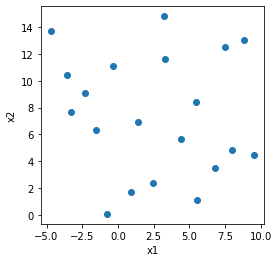

In [2]:
# -----------------------------------------------------------------------------
# LHS
dim = 2
sample = 10 * dim
# this return scaled inputs, dimension: (20, 2)
x_scaled = doe.lhs(dim, samples=sample, criterion='maximin')
# -----------------------------------------------------------------------------
# # grid designs
# dim = 2
# N = 10
# x_1 = np.linspace(0, 1, N)
# x_2 = np.linspace(0, 1, N)
# xx_1, xx_2 = np.meshgrid(x_1, x_2)
# x_scaled = np.stack((xx_1.flatten(),xx_2.flatten()), axis=-1)
# -----------------------------------------------------------------------------


# unscale input between the actual bounds: -5 <= x_1 <= 10, 0 <= x_2 <= 15
bounds = np.array([[-5, 10], [0, 15]]).T
x = x_scaled.copy()
for i in range(dim):
    x[:, i] = x_scaled[:, i] * (bounds[1, i] - bounds[0, i]) + bounds[0, i]

# call the blackbox function to generate outputs
y = blackbox(x)

# scale y
y_scaled = (y - min(y)) / (max(y) - min(y))

# optional: visualization of sampling points
fig, ax = plt.subplots(figsize=plt.figaspect(1.0))
ax.scatter(x[:, 0], x[:, 1])
ax.set(xlabel='x1', ylabel='x2')
plt.show()


## Problem 2
### Mapping inputs to features

In [3]:
import pyomo.environ as pe

# define two functions to generate new features
def mat_1(x):
    """Return matrix of 1, x1, x2, x1^2, x2^2, x1^4, cos(x1), x1 * x2. Dimension: (n_samples, 8)"""
    m, n = np.shape(x)
    mat = np.array([np.ones(m), x[:,0], x[:,1], x[:,0]**2, x[:,1]**2, x[:,0]**4, np.cos(x[:,0]), x[:,0]*x[:,1]]).T
    return mat

def mat_2(x):
    """Return matrix of 1, x1, x2, x1^2, x1^3, x2^2, x2^3, x1 * x2, x1^2 * x2, x1 * x2^2. Dimension: (n_samples, 10)"""
    m, n = np.shape(x)
    mat = np.array([np.ones(m), x[:,0], x[:,1], x[:,0]**2, x[:,0]**3, x[:,1]**2, x[:,1]**3, x[:,0]*x[:,1],(x[:,0]**2) * x[:,1], x[:,0] * (x[:,1]**2)]).T
    return mat

# generate new features
X_new = {}
X_new['I1'] = mat_1(x_scaled)
X_new['I2'] = mat_2(x_scaled)

### 2(a) 

In [4]:
# CV from sklearn
from sklearn.model_selection import KFold

# create k-fold object
kf = KFold(n_splits=5, shuffle=True)

# lambda value set
lbda_set = np.logspace(-4, 0, num=11)

# create dict for average error of each feature set, and each lambda value
overall_avg_error = {}

# train the model for both feature sets
for feature_i, X in X_new.items():
    
    print(f'Feature set {feature_i}:')
    
    # create index list for features
    feature_list = list(range(X.shape[1]))
    
    # create dict for average error of each lambda value
    avg_error = {}
    
    # grid-search lambda
    for lbda in lbda_set:
        

        # create dictionary to record trained model for each fold
        CV_models = []

        # 5-fold CV
        for train_index, test_index in kf.split(X):
            
            # split training and test set
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_scaled[train_index], y_scaled[test_index]

            # create index list for training points
            train_point_list = list(range(X_train.shape[0]))

            # -----------------------------------------------------------------------------------
            # Pyomo model
            m = pe.ConcreteModel()

            # define variables
            m.b = pe.Var(feature_list, within=pe.Reals)
            m.y_p = pe.Var(train_point_list, within=pe.Reals)
            m.b_p = pe.Var(feature_list, within=pe.NonNegativeReals)
            m.b_n = pe.Var(feature_list, within=pe.NonNegativeReals)

            # define objective function
            def obj_rule(m):
                return sum((m.y_p[i] - y_train[i]) ** 2 for i in train_point_list) + lbda * sum(m.b_p[j] + m.b_n[j] for j in feature_list)
            m.obj = pe.Objective(rule=obj_rule)

            # define constraints
            def con_rule1(m, i):
                return m.y_p[i] == sum(m.b[j] * X_train[i, j] for j in feature_list)
            m.con1 = pe.Constraint(train_point_list, rule=con_rule1)
            def con_rule2(m, j):
                return m.b[j] == m.b_p[j] - m.b_n[j]
            m.con2 = pe.Constraint(feature_list, rule=con_rule2)

            # solve model using ipopt
            solver = pe.SolverFactory('ipopt')
            solver.solve(m)
            # -----------------------------------------------------------------------------------
            
            # record model for this fold
            tmp_model = {}
            # record objective value
            tmp_model['obj'] = pe.value(m.obj)
            # record parameter value
            tmp_model['b'] = np.empty((len(feature_list)))
            for i in feature_list:
                tmp_model['b'][i] = pe.value(m.b[i])
            # calculate test error
            tmp_model['error'] = sum((np.matmul(X_test, tmp_model['b'].T) - y_test) ** 2)
            # record the model in CV_models
            CV_models.append(tmp_model)
        
        # calculate average error of 5-fold CV
        avg_error[lbda] = sum(model['error'] for model in CV_models) / len(CV_models)
        
        print(f'\tlambda = {lbda:.1e}\taverage error = {avg_error[lbda]:.5f}')
        
    # record error in overall_avg_error
    overall_avg_error[feature_i] = avg_error

# compare errors
best_error = {'I1': {}, 'I2': {}}
best_error['I1']['lambda'] = min(overall_avg_error['I1'], key=overall_avg_error['I1'].get)
best_error['I1']['error'] = overall_avg_error['I1'][best_error['I1']['lambda']]
best_error['I2']['lambda'] = min(overall_avg_error['I2'], key=overall_avg_error['I2'].get)
best_error['I2']['error'] = overall_avg_error['I2'][best_error['I2']['lambda']]

if best_error['I1']['error'] <= best_error['I2']['error']:
    better_feature_i = 'I1'
else:
    better_feature_i = 'I2'

# record better feature set and corresponding lambda
better_X = X_new[better_feature_i]
best_lambda = best_error[better_feature_i]['lambda']

print(f"\nBest feature set: {better_feature_i}, with lambda = {best_error[better_feature_i]['lambda']:.1e}, "
      f"error = {best_error[better_feature_i]['error']:.5f}.")

Feature set I1:
	lambda = 1.0e-04	average error = 0.00258
	lambda = 2.5e-04	average error = 0.00307
	lambda = 6.3e-04	average error = 0.00435
	lambda = 1.6e-03	average error = 0.00448
	lambda = 4.0e-03	average error = 0.00946
	lambda = 1.0e-02	average error = 0.01278
	lambda = 2.5e-02	average error = 0.04486
	lambda = 6.3e-02	average error = 0.04682
	lambda = 1.6e-01	average error = 0.05127
	lambda = 4.0e-01	average error = 0.05828
	lambda = 1.0e+00	average error = 0.13919
Feature set I2:
	lambda = 1.0e-04	average error = 0.01393
	lambda = 2.5e-04	average error = 0.01453
	lambda = 6.3e-04	average error = 0.01172
	lambda = 1.6e-03	average error = 0.00831
	lambda = 4.0e-03	average error = 0.01460
	lambda = 1.0e-02	average error = 0.01105
	lambda = 2.5e-02	average error = 0.01308
	lambda = 6.3e-02	average error = 0.01500
	lambda = 1.6e-01	average error = 0.02407
	lambda = 4.0e-01	average error = 0.15454
	lambda = 1.0e+00	average error = 0.29027

Best feature set: I1, with lambda = 1.0e-04

### 2(b)

In [5]:
# create index list for all sample points
all_point_list = list(range(better_X.shape[0]))
# create index list for features
feature_list = list(range(better_X.shape[1]))

m = pe.ConcreteModel()

m.b = pe.Var(feature_list, within=pe.Reals)
m.y_p = pe.Var(all_point_list, within=pe.Reals)
m.b_p = pe.Var(feature_list, within=pe.NonNegativeReals)
m.b_n = pe.Var(feature_list, within=pe.NonNegativeReals)

def obj_rule(m):
    return sum((m.y_p[i] - y_scaled[i]) ** 2 for i in all_point_list) + best_lambda * sum(m.b_p[j] + m.b_n[j] for j in feature_list)
m.obj = pe.Objective(rule=obj_rule)

def con_rule1(m, i):
    return m.y_p[i] == sum(m.b[j] * better_X[i, j] for j in feature_list)
m.con1 = pe.Constraint(all_point_list, rule=con_rule1)
def con_rule2(m, j):
    return m.b[j] == m.b_p[j] - m.b_n[j]
m.con2 = pe.Constraint(feature_list, rule=con_rule2)

solver = pe.SolverFactory('ipopt')
solver.solve(m)

# report optimal parameters and objective function
best_b = []
print("Optimal b:",end='\t')
for i in feature_list:
    best_b.append(pe.value(m.b[i]))
    print(f"{best_b[-1]:.4f}",end='\t')
print(f"\nObjective value: {pe.value(m.obj):.5f}")

Optimal b:	0.5160	-1.6545	-1.1454	1.5993	0.6604	-0.3599	0.0000	1.7867	
Objective value: 0.00620


### c)

In [6]:
# generate surrogate model surr_2c

# dictionary for features
terms = {}
terms['I1'] = ['1', 'm.x1', 'm.x2', 'm.x1**2', 'm.x2**2', 'm.x1**4', 'pe.cos(m.x1)', 'm.x1*m.x2']
terms['I2'] = ['1', 'm.x1', 'm.x2', 'm.x1**2', 'm.x1**3', 'm.x2**2', 'm.x2**3', 'm.x1*m.x2', 'm.x1**2*m.x2', 'm.x1*m.x2**2']

def surr_generator_pyomo(terms, b):
    """Return a string of surrogate model expression for pyomo model"""
    expr = ''
    for k in range(len(b)):
        if b[k] >= 0:
            expr = expr + '+' + str(b[k]) + '*' + terms[k]
        else:
            expr = expr + str(b[k]) + '*' + terms[k]
    return expr

# string for pyomo model expression
surr_2c_str = surr_generator_pyomo(terms[better_feature_i], best_b)

# create Pyomo model for surr_2c

m_surr_2c = pe.ConcreteModel()
m_surr_2c.x1 = pe.Var(bounds=(-5,10),initialize=0.5)
m_surr_2c.x2 = pe.Var(bounds=(0,15),initialize=0.5)

def surr_2c_obj(m):
    """Transform the surrogate model expression string to python expression"""
    return eval(surr_2c_str)

m_surr_2c.obj = pe.Objective(rule=surr_2c_obj)
solver = pe.SolverFactory('ipopt')
solver.solve(m_surr_2c)

# record and print unscaled result
result_surr_2c = {}
result_surr_2c['x1'] = pe.value(m_surr_2c.x1) * (bounds[1,0] - bounds[0,0]) + bounds[0,0]
result_surr_2c['x2'] = pe.value(m_surr_2c.x2) * (bounds[1,1] - bounds[0,1]) + bounds[0,1]
result_surr_2c['obj'] = pe.value(m_surr_2c.obj) * (max(y) - min(y)) + min(y)
print("Optimal solution of surrogate model 2(c):")
for key, value in result_surr_2c.items():
    print(f"\t{key}:\t{value:.2f}")

Optimal solution of surrogate model 2(c):
	x1:	-2.91
	x2:	10.18
	obj:	6.93


In [7]:
# OPTIONAL: for comparison, create Pyomo model for original black-box function
m_origin = pe.ConcreteModel()
m_origin.x1 = pe.Var(bounds=(-5, 10), initialize=0.01)
m_origin.x2 = pe.Var(bounds=(0, 15), initialize=0.5)

def obj(m):
    return 10 + 10 * (1 - 1/8/np.pi) * pe.cos(m.x1) + (m.x2 - (5.1/16/(np.pi**2)) * (m.x1) ** 2 + 5 / np.pi * m.x1 - 6)**2
m_origin.obj = pe.Objective(rule=obj)
solver = pe.SolverFactory('ipopt')
solver.solve(m_origin)

result_origin = {}
result_origin['x1'] = pe.value(m_origin.x1)
result_origin['x2'] = pe.value(m_origin.x2)
result_origin['obj'] = pe.value(m_origin.obj)
print("Optimal solution of original function:")
for key, value in result_origin.items():
    print(f"\t{key}:\t{value:.2f}")

Optimal solution of original function:
	x1:	3.14
	x2:	1.32
	obj:	0.40


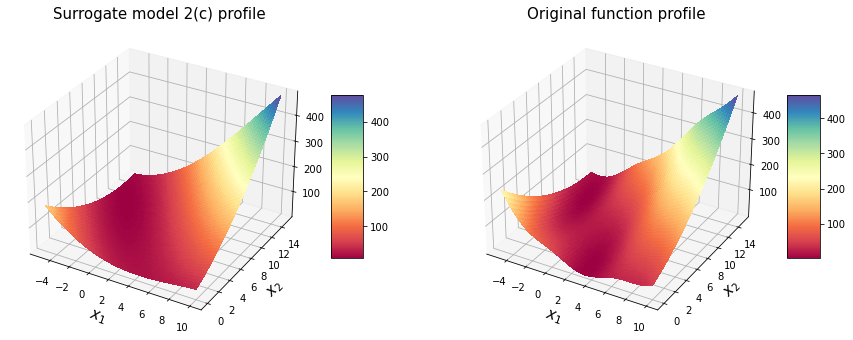

In [8]:
# OPTIONAL: compare model profile

def surr_generator(terms, b):
    """Return a string of surrogate model python expression"""
    expr = ''
    for k in range(len(b)):
        if b[k] >= 0:
            expr = expr + '+' + str(b[k]) + '*' + terms[k].replace('m.', '')
        else:
            expr = expr + str(b[k]) + '*' + terms[k].replace('m.', '')
    return expr

# surrogate model (in python function)
def surr_2c(x1, x2):
    return eval(surr_generator(terms[better_feature_i], best_b))

# setup grid
x_1_range = np.linspace(-5, 10, 100)
x_2_range = np.linspace(0, 15, 100)
x_range = np.transpose(np.array([x_1_range, x_2_range]))
X_1, X_2 = np.meshgrid(x_1_range, x_2_range)

# compute model values
m, n = X_1.shape
surr_2c_value = np.zeros((m, n))
blackbox_value = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        surr_2c_value[i, j] = surr_2c((X_1[i, j]+5)/15, X_2[i, j]/15) * (max(y) - min(y)) + min(y)
        blackbox_value[i, j] = blackbox(np.array([X_1[i, j], X_2[i, j]]).reshape(1, -1))

# plot profile
fig, ax = plt.subplots(1,2, subplot_kw={"projection":"3d"}, figsize=(15,15))

# plot surrogate model
surf_1 = ax[0].plot_surface(X_1, X_2, surr_2c_value, cmap=plt.cm.Spectral, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_title('Surrogate model 2(c) profile', fontsize=15)
fig.colorbar(surf_1, ax=ax[0], shrink=0.2, aspect=5)

# plot original function
surf_2 = ax[1].plot_surface(X_1, X_2, blackbox_value, zorder=1, cmap=plt.cm.Spectral, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_title('Original function profile', fontsize=15)
fig.colorbar(surf_2, ax=ax[1], shrink=0.2, aspect=5)

## 3 
### 3(a)

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

# create GPR model, with RBF kernel
gp = GPR(kernel=RBF(0.1, (1e-2, 1e2)))

cv_e = {}
cv_data = {}

# cross validation 
i = 0
for train_index, test_index in kf.split(x_scaled):
    
    # split training and testing set
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    
    # fit GPR model
    gpmodel = gp.fit(x_train, y_train)
    
    # predict
    y_pred = np.array(gpmodel.predict(x_test))
    
    # calculate error
    err = sum((y_pred - y_test)**2)
    
    # record data and error
    cv_e[i] = err
    cv_data[i] = {'x': x_train,'y': y_train}
    
    i += 1

# pick the best model
best_cv = min(cv_e, key=cv_e.get)
best_data = cv_data[best_cv]
best_gp = gp.fit(best_data['x'],best_data['y'])

# calculate the average CV error
print(f"average CV error: {sum(cv_e[i] for i in range(len(cv_e)))/len(cv_e):.4f}")

average CV error: 0.0569


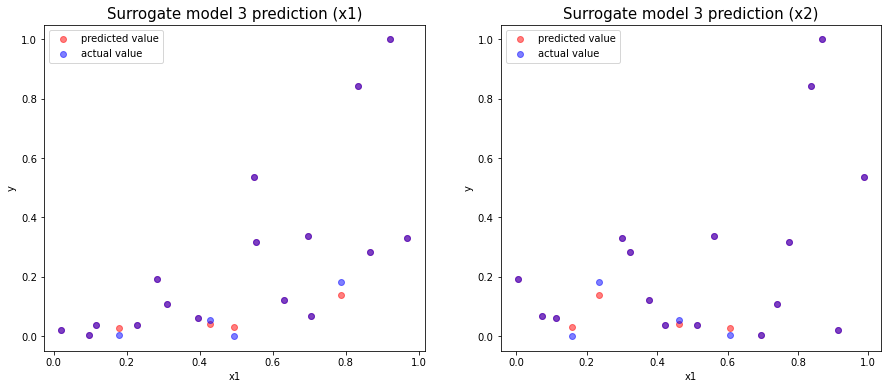

In [10]:
# visualize prediction
fig, ax = plt.subplots(1, 2, figsize=(15,6))

y_gp = best_gp.predict(x_scaled)

ax[0].scatter(x_scaled[:,0], y_gp, color='red', alpha=0.5, label='predicted value')
ax[0].scatter(x_scaled[:,0], y_scaled, color='blue', alpha=0.5, label='actual value')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('y')
ax[0].set_title('Surrogate model 3 prediction (x1)', fontsize=15)
ax[0].legend()

ax[1].scatter(x_scaled[:,1], y_gp, color='red', alpha=0.5, label='predicted value')
ax[1].scatter(x_scaled[:,1], y_scaled, color='blue', alpha=0.5, label='actual value')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('y')
ax[1].set_title('Surrogate model 3 prediction (x2)', fontsize=15)
ax[1].legend()

plt.show()

### 3(b)

In [11]:
import scipy

# define wrapper function
def gp_model(guess):
    test = np.array([[guess[0],guess[1]]])
    return best_gp.predict(test)[0]

# optimize the best GP model
initial_guess = np.array([0.5,0.5])
bnds = ((0, 1), (0, 1))
gp_optimize_result = scipy.optimize.minimize(gp_model, initial_guess, bounds=bnds, method='TNC')

# print results
result_surr_3 = {}
result_surr_3['x1'] = gp_optimize_result.x[0] * (bounds[1, 0] - bounds[0, 0]) + bounds[0, 0]
result_surr_3['x2'] = gp_optimize_result.x[1] * (bounds[1, 1] - bounds[0, 1]) + bounds[0, 1]
result_surr_3['obj'] = gp_optimize_result.fun * (max(y) - min(y)) + min(y)
print("Optimal solution of surrogate model 3:")
for key, value in result_surr_3.items():
    print(f"\t{key}:\t{value:.2f}")

Optimal solution of surrogate model 3:
	x1:	1.21
	x2:	4.71
	obj:	7.69


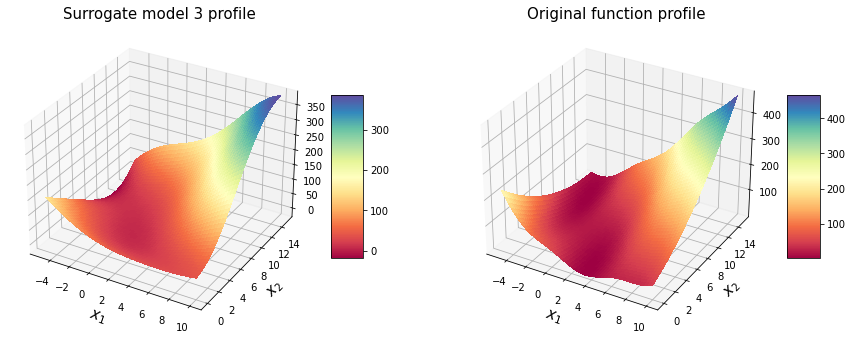

In [12]:
# OPTIONAL: compare model profile

# setup grid
x_1_range = np.linspace(-5, 10, 100)
x_2_range = np.linspace(0, 15, 100)
x_range = np.transpose(np.array([x_1_range, x_2_range]))
X_1, X_2 = np.meshgrid(x_1_range, x_2_range)

# compute model values
m, n = X_1.shape
surr_3_value = np.zeros((m, n))
blackbox_value = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        surr_3_value[i, j] = best_gp.predict(np.array(((X_1[i, j]+5)/15, X_2[i, j]/15)).reshape(1, -1))[0] * (max(y) - min(y)) + min(y)
        blackbox_value[i, j] = blackbox(np.array([X_1[i, j], X_2[i, j]]).reshape(1, -1))

# plot profile
fig, ax = plt.subplots(1,2, subplot_kw={"projection":"3d"}, figsize=(15,15))

# plot surrogate model
surf_1 = ax[0].plot_surface(X_1, X_2, surr_3_value, cmap=plt.cm.Spectral, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_title('Surrogate model 3 profile', fontsize=15)
fig.colorbar(surf_1, ax=ax[0], shrink=0.2, aspect=5)

# plot original function
surf_2 = ax[1].plot_surface(X_1, X_2, blackbox_value, zorder=1, cmap=plt.cm.Spectral, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_title('Original function profile', fontsize=15)
fig.colorbar(surf_2, ax=ax[1], shrink=0.2, aspect=5)

## 4

In [13]:
# lambda value set
C_set = np.logspace(-4, 2, num=11)

# epsilon
epsilon = 0.001

# create index list for features
feature_list = list(range(x_scaled.shape[1]))

# create dict for average error of each C value and each model
avg_error = {}
best_models = {}

# grid-search C
for C in C_set:

    # create dictionary to record trained model for each fold
    CV_models = []
    CV_error = []

    # 5-fold CV
    for train_index, test_index in kf.split(X):

        # split training and test set
        x_train, x_test = x_scaled[train_index], x_scaled[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]

        # create index list for training points
        train_point_list = list(range(x_train.shape[0]))

        # -----------------------------------------------------------------------------------
        # Pyomo model
        m = pe.ConcreteModel()

        # define variables
        m.w = pe.Var(feature_list, within=pe.Reals)
        m.b = pe.Var(within=pe.Reals)
        m.xi_p = pe.Var(train_point_list, within=pe.NonNegativeReals)
        m.xi_n = pe.Var(train_point_list, within=pe.NonNegativeReals)

        # define objective function
        def obj_rule(m):
            return 0.5 * sum(m.w[i] ** 2 for i in feature_list) + C * sum(m.xi_p[j] + m.xi_n[j] for j in train_point_list)
        m.obj = pe.Objective(rule=obj_rule)

        # define constraints
        def con_rule1(m, j):
            return - m.b - sum(m.w[i] * x_train[j, i] for i in feature_list) + y_train[j] <= epsilon + m.xi_p[j]
        m.con1 = pe.Constraint(train_point_list, rule=con_rule1)
        def con_rule2(m, j):
            return m.b + sum(m.w[i] * x_train[j, i] for i in feature_list) - y_train[j] <= epsilon + m.xi_n[j]
        m.con2 = pe.Constraint(train_point_list, rule=con_rule2)

        # solve model using ipopt
        solver = pe.SolverFactory('ipopt')
        solver.solve(m)
        # -----------------------------------------------------------------------------------

        # record model for this fold
        tmp_model = {}
        # record objective value
        tmp_model['obj'] = pe.value(m.obj)
        # record parameter value
        tmp_model['w'] = np.empty((len(feature_list)))
        for i in feature_list:
            tmp_model['w'][i] = pe.value(m.w[i])
        # calculate test error
        CV_error.append(sum((np.matmul(x_test, tmp_model['w'].T) - y_test) ** 2))
        # record the model in CV_models
        CV_models.append(tmp_model)

    # calculate average error of 5-fold CV
    avg_error[C] = sum(i for i in CV_error) / len(CV_error)
    print(f'\tC = {C:.1e}\taverage error = {avg_error[C]:.5f}')
    
    # record the best model for a fixed C value
    best_fold = np.argmin(CV_error)
    best_models[C] = CV_models[best_fold]

# compare errors
best_C = min(avg_error, key=avg_error.get)
best_model = best_models[best_C]
print(f"\nOptimal C:\t\t\t{best_C:.1e}")
print(f"Optimal objective value: \t{best_model['obj']:.4f}")
print(f"Optimal weight: \t\t{best_model['w']}")

	C = 1.0e-04	average error = 0.50153
	C = 4.0e-04	average error = 0.50005
	C = 1.6e-03	average error = 0.49500
	C = 6.3e-03	average error = 0.47504
	C = 2.5e-02	average error = 0.40243
	C = 1.0e-01	average error = 0.24506
	C = 4.0e-01	average error = 0.21482
	C = 1.6e+00	average error = 0.46754
	C = 6.3e+00	average error = 0.47604
	C = 2.5e+01	average error = 0.62627
	C = 1.0e+02	average error = 0.60567

Optimal C:			4.0e-01
Optimal objective value: 	0.8443
Optimal weight: 		[0.46849114 0.23291039]


## 5
### 5(a)

<ipython-input-14-c196a7463e47>:9: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  data = pd.read_excel('ENB2012_data.xlsx',nrows=768)
/Users/chengpengfei/anaconda3/envs/6746/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


PC1: 46.29%
PC2: 15.50%
PC3: 15.16%
PC4: 12.50%
PC5: 9.84%
PC6: 0.66%
PC7: 0.06%
PC8: 0.00%


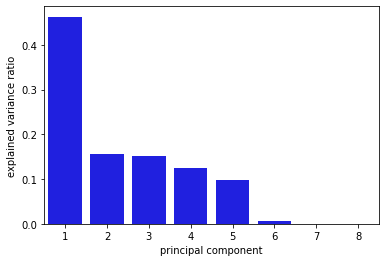

In [14]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import data
data = pd.read_excel('ENB2012_data.xlsx',nrows=768)
# split inputs and outputs
X1=data[['Relative_Compactness','Surface_Area',
         'Wall_Area','Roof_Area','Height','Orientation',
         'Glazing_Area','Glazing_A_Distribution']]
Y1=data[['Heating_Load','Cooling_Load']]

# scale inputs
X1 = StandardScaler().fit_transform(X1)

# fit PCA model to input
pca = PCA().fit(X1)
# print explained variance ratio
for i, evr in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {evr:.2%}")

fig, ax = plt.subplots()
sns.barplot(np.arange(1, len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_,color='blue')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance ratio')
plt.show()

a) I would only keep 2 or at most three PCs. Above 99% of variance is explained by PC1 and PC2. 

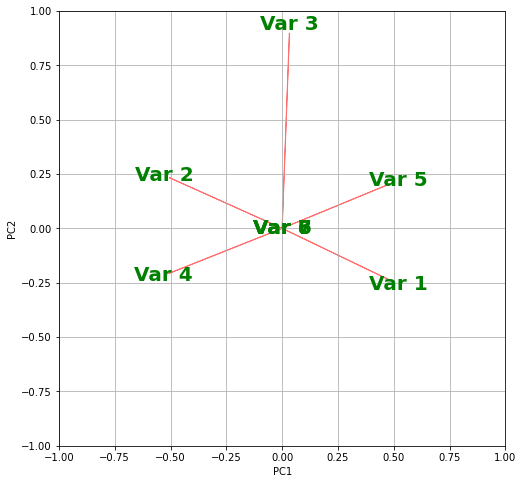

In [15]:
# run PCA, see which variables contribute most
pc = pca.fit_transform(X1)


# define function to plot loading plot
def loading_plot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0] * 1.05, coeff[i,1] * 1.05, "Var " + str(i + 1), color='g', ha='center', va='center', size=20, weight='bold')
        else:
            plt.text(coeff[i,0] * 1.05, coeff[i,1] * 1.05, labels[i], color='g', ha='center', va='center', size=20, weight='bold')

fig, ax = plt.subplots(figsize=(8, 8))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

# call the function with the first two PCs
loading_plot(pc[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()